In [1]:
import os

In [2]:
import ultralytics
from ultralytics import YOLO

ultralytics.checks()

Ultralytics 8.3.139 🚀 Python-3.10.14 torch-2.7.0 CPU (Apple M1 Pro)
Setup complete ✅ (10 CPUs, 32.0 GB RAM, 440.5/926.4 GB disk)


In [3]:
from IPython import display

display.clear_output()

In [4]:
import supervision as sv

print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.25.1


In [11]:
SOURCE_VIDEO_PATH = f"../data/materialy/wydzial.mp4"
RESULTS_PATH = f"../results/count_objects"

In [12]:
model = YOLO("yolo11n.pt")

In [13]:
CLASS_NAMES_DICT = model.model.names

SELECTED_CLASS_NAMES = ['person']

SELECTED_CLASS_IDS = [
    {value: key for key, value in CLASS_NAMES_DICT.items()}[class_name]
    for class_name
    in SELECTED_CLASS_NAMES
]

In [14]:
import supervision as sv
import numpy as np
import cv2

In [15]:
import inspect
from supervision import LineZoneAnnotator

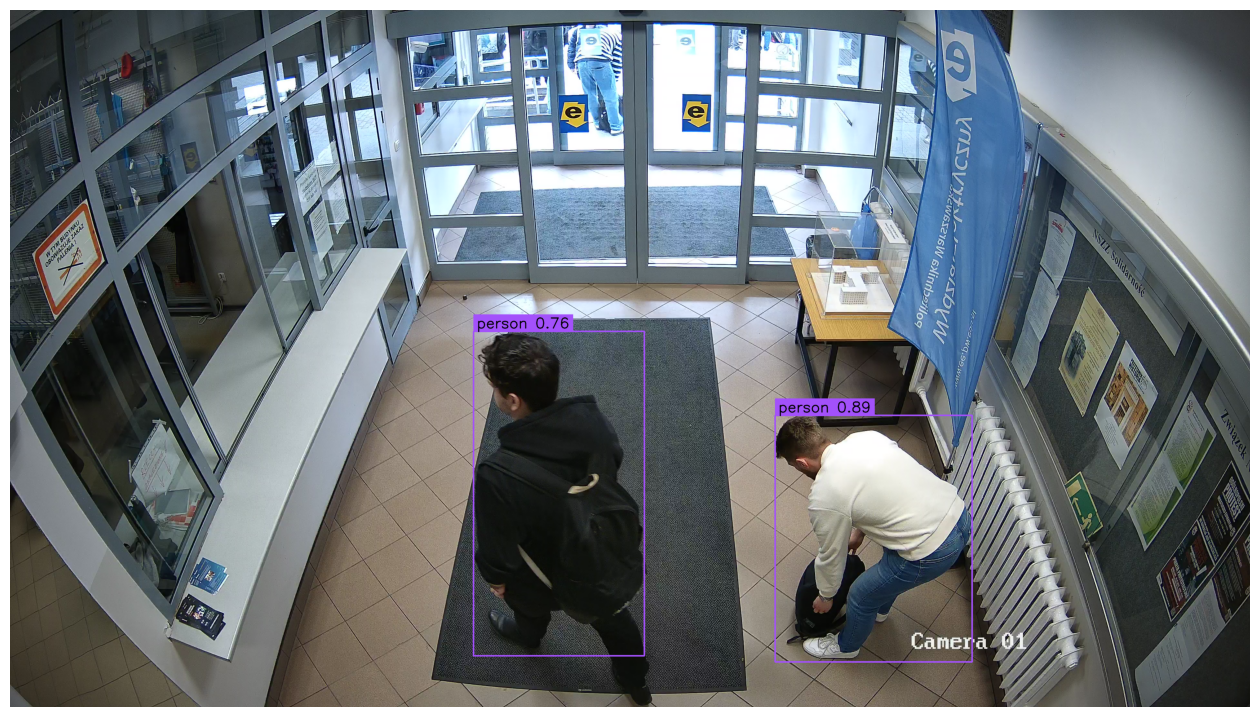

In [16]:
import cv2
import numpy as np
import supervision as sv

generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)

iterator = iter(generator)
frame = next(iterator)

results = model(frame, verbose=False)[0]
detections = sv.Detections.from_ultralytics(results)

detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]

labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

# ▶️ Add horizontal line
# line_y = annotated_frame.shape[0] // 2  # vertical middle of the frame
# cv2.line(annotated_frame, (0, line_y), (annotated_frame.shape[1], line_y), color=(0, 0, 255), thickness=2)

# ▶️ Display the frame
%matplotlib inline
sv.plot_image(annotated_frame, (16, 16))


In [17]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=7550)

In [18]:
LINE_START = sv.Point(3840, 850)
LINE_END = sv.Point(0, 850)

TARGET_VIDEO_PATH = os.path.join(RESULTS_PATH, "wydzial_result.mp4")

In [13]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(
    track_activation_threshold=0.25,
    lost_track_buffer=30,
    minimum_matching_threshold=0.8,
    frame_rate=30,
    minimum_consecutive_frames=3)

byte_tracker.reset()

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator, LabelAnnotator, and TraceAnnotator
box_annotator = sv.BoxAnnotator(thickness=4)
label_annotator = sv.LabelAnnotator(text_thickness=2, text_scale=1.5, text_color=sv.Color.BLACK)
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2, text_orient_to_line=True)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, SELECTED_CLASS_IDS)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = frame.copy()
    annotated_frame = trace_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = box_annotator.annotate(
        scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(
        scene=annotated_frame, detections=detections, labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)